# Data Exploration

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from zotbin.group import *
from zotbin.binned import get_zedges_chi

In [3]:
from tomo_challenge import load_data, load_redshift

Found classifier Random
Found classifier RandomForest
Found classifier IBandOnly


Load the riz training data:

In [4]:
bands='riz'
include_colors=False
include_errors=False

In [5]:
train_file='/media/data2/tomo_challenge_data/ugrizy_buzzard/training.hdf5'
train_data = load_data(train_file, bands, 
                       errors=include_errors,
                       colors=include_colors, array=True)
train_z = load_redshift(train_file)
print(f'Loaded {len(train_data)} training rows.')

Loaded 5410171 training rows.


/home/dkirkby/DESC/tomo/tomo_challenge/data.py:89: UserWarning: Setting inf (undetected) bands to mag=30
  warnings.warn("Setting inf (undetected) bands to mag=30")


Use i-r, z-i and i as the input features:

In [6]:
def prepare(band='i', nmax=None, shuffle=False, seed=123):
    n = min(nmax or len(train_data), len(train_data))
    colors = np.diff(train_data, axis=1)
    i = bands.index(band)
    if shuffle:
        gen = np.random.RandomState(seed)
        idx = gen.choice(len(train_data), n, replace=False)
    else:
        idx = slice(None)
    return np.concatenate((colors[idx], train_data[idx, i:i + 1]), axis=1), train_z[idx]

In [7]:
X, z = prepare()

Specify hyperparameters:

In [15]:
npct = 16
nzbin = 120
ngrp = 200

Calculate redshift bins equally spaced in comoving distance:

In [11]:
zedges = get_zedges_chi(z, nzbin=120)

/opt/anaconda3/envs/ML/lib/python3.7/site-packages/jax/lax/lax.py:5905: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


Plot the feature space rectangular grid:

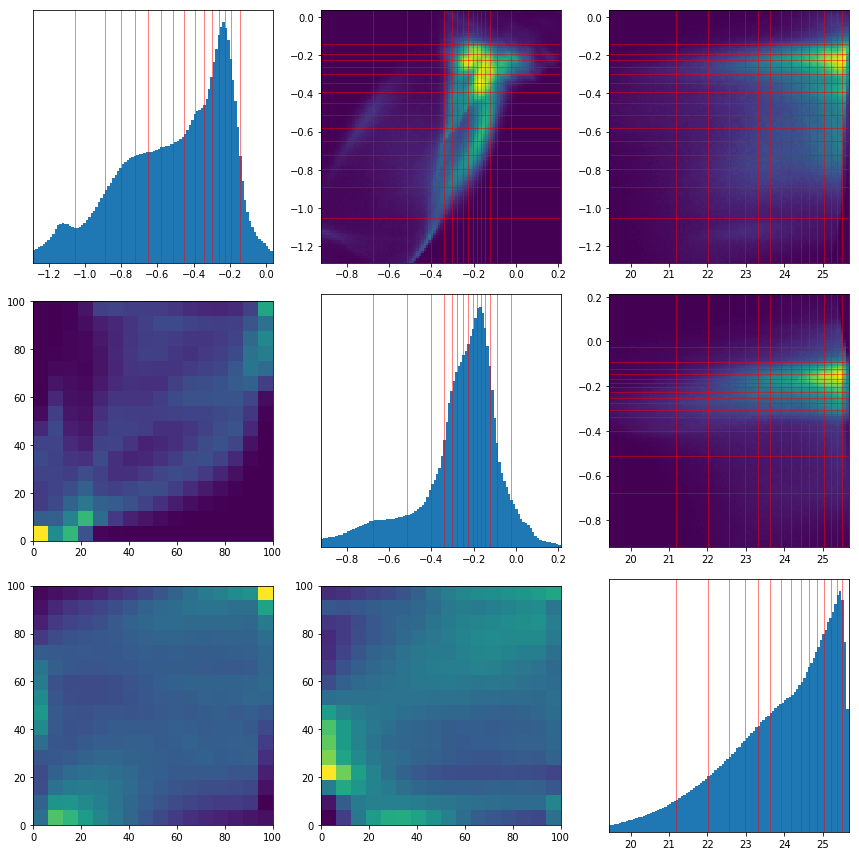

In [9]:
plotfbins(X, npct)

Plot the  corresponding redshift vectors:

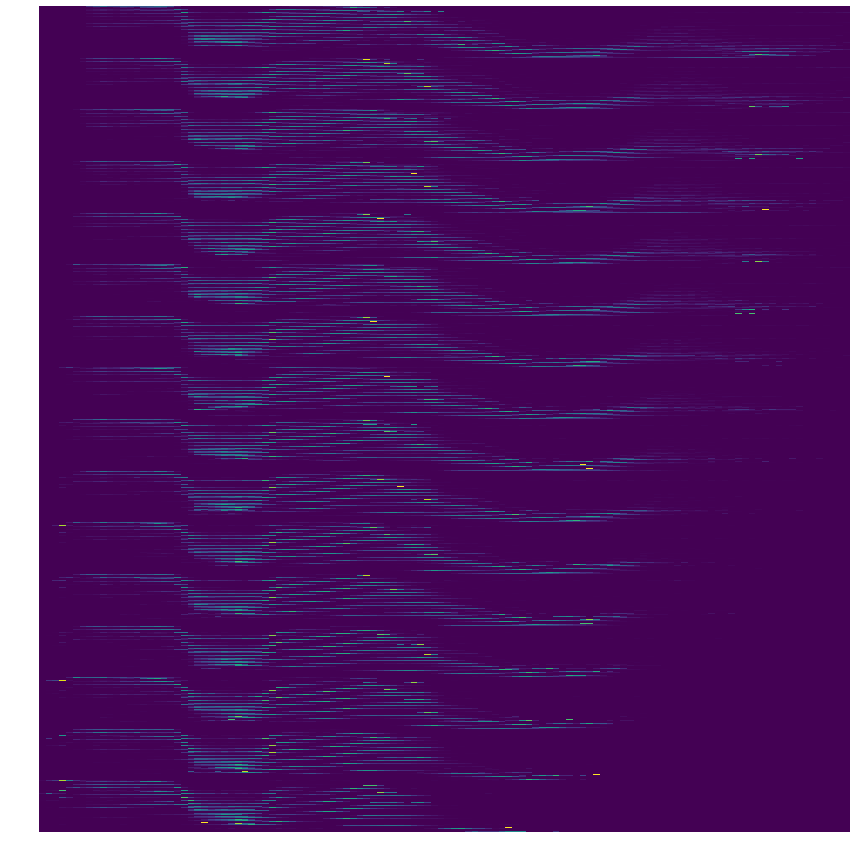

In [12]:
plotzvecs(X, z,  zedges, npct)

Calculate feature-space groups with a weighted redshift similarity measure:

In [13]:
%time fedges, grpid, zhist, zsim = groupbins(X, z, zedges, npct, min_groups=ngrp, weighted=True)

Grouping with ndata=5410171, nmin=27051, nmax=108203, nzbin=120, nfbin=4096.
Reduced to 3587 groups after 100 iterations.
Reduced to 3487 groups after 200 iterations.
Reduced to 3387 groups after 300 iterations.
Reduced to 3287 groups after 400 iterations.
Reduced to 3245 groups after 500 iterations.
Reduced to 3166 groups after 600 iterations.
Reduced to 3068 groups after 700 iterations.
Reduced to 2991 groups after 800 iterations.
Reduced to 2921 groups after 900 iterations.
Reduced to 2821 groups after 1000 iterations.
Reduced to 2753 groups after 1100 iterations.
Reduced to 2753 groups after 1200 iterations.
Reduced to 2747 groups after 1300 iterations.
Reduced to 2668 groups after 1400 iterations.
Reduced to 2572 groups after 1500 iterations.
Reduced to 2478 groups after 1600 iterations.
Reduced to 2383 groups after 1700 iterations.
Reduced to 2321 groups after 1800 iterations.
Reduced to 2315 groups after 1900 iterations.
Reduced to 2223 groups after 2000 iterations.
Reduced to 2

and with an un-weighted redshift similarity measure:

In [ ]:
%time fedges2, grpid2, zhist2, zsim2 = groupbins(X, z, zedges, npct, min_groups=ngrp, weighted=False)

Save the results:

In [16]:
np.savez(f'groups_{npct}_{nzbin}_{ngrp}.npz', fedges=fedges, grpid=grpid, zhist=zhist, zsim=zsim)

Do a small test with validation turned on:

In [ ]:
groupbins(X[:10000], z[:10000], zedges, npct=10, min_groups=ngrp, weighted=True, validate=True, validate_interval=100)

Grouping with ndata=10000, nmin=50, nmax=200, nzbin=120, nfbin=1000.
validating similarity matrices after 100 iterations
Reduced to 764 groups after 100 iterations.
validating similarity matrices after 200 iterations
Reduced to 706 groups after 200 iterations.
validating similarity matrices after 300 iterations
Reduced to 676 groups after 300 iterations.
validating similarity matrices after 400 iterations


In [9]:
def pairs_iterator(grpid, active):
    """Iterate over pairs of groups and perform some validations.
    """
    ids = np.unique(grpid)
    for i, id1 in enumerate(ids):
        sel1 = grpid == id1
        idx1 = np.where(sel1)[0]
        assert np.all(grpid[idx1] == np.min(idx1))
        if not np.any(active[sel1]):
            continue
        # Only the first bin in each group must be active.
        assert active[idx1[0]] and not np.any(active[idx1[1:]])
        for id2 in ids[i + 1:]:
            sel2 = grpid == id2
            idx2 = np.where(sel2)[0]
            assert np.all(grpid[idx2] == np.min(idx2))
            if not np.any(active[sel2]):
                continue
            # Only the first bin in each group must be active.
            assert active[idx2[0]] and not np.any(active[idx2[1:]])
            # Groups must be disjoint.
            assert not np.any(sel1 & sel2)
            yield idx1, idx2

In [10]:
def feature_similarity(dr2, grpid, active):
    """Calculate the feature similarity matrix from scratch.
    This is relatively slow so only used to validate faster incremental updates.
    """
    fsim = np.zeros_like(dr2)
    for idx1, idx2 in pairs_iterator(grpid, active):
        # Find the minimum separation between bins in these groups.
        dr2sub = dr2[np.ix_(idx1, idx2)]
        dr2min = np.min(dr2sub)
        # Save the result.
        gnorm = np.exp(-dr2min)
        fsim[idx1[0], idx2[0]] = gnorm
        fsim[idx2[0], idx1[0]] = gnorm
    # The similarities of inactive rows and columns should already be zero.
    assert np.all(fsim[~active, :] == 0)
    assert np.all(fsim[:, ~active] == 0)
    return fsim

In [11]:
def redshift_similarity(zhist, znorm, grpid, active, weighted):
    """Calculate the redshift similarity matrix from scratch.
    This is relatively slow so only used to validate faster incremental updates.
    """
    nfbin, nzbin = zhist.shape
    zsim = np.zeros((nfbin, nfbin))
    for idx1, idx2 in pairs_iterator(grpid, active):
        idx1 = idx1[0]
        idx2 = idx2[0]
        assert znorm[idx1] > 0 and znorm[idx2] > 0
        if weighted:
            z12norm = np.sqrt(np.sum((zhist[idx1] + zhist[idx2]) ** 2))
            z12sim = z12norm / (znorm[idx1] + znorm[idx2])
        else:
            z12dot = np.sum(zhist[idx1] * zhist[idx2])
            z12sim = z12dot / (znorm[idx1] * znorm[idx2])
        zsim[idx1, idx2] = z12sim
        zsim[idx2, idx1] = z12sim
    # The similarities of inactive rows and columns should already be zero.
    assert np.all(zsim[~active, :] == 0)
    assert np.all(zsim[:, ~active] == 0)
    return zsim

In [12]:
def validated(M1, M2):
    """Test if M1 and M2 are the same matrix"""
    assert M1.shape == M2.shape
    if np.allclose(M1, M2):
        return True
    else:
        diff = np.abs(M1 - M2)
        i, j = np.unravel_index(np.argmax(diff), M1.shape)
        print(f'max diff at [{i},{j}]: |{M1[i,j]}-{M2[i,j]}| = {diff[i,j]}')
        return False

In [148]:
def get_fedges(features, npct):
    ndata, nfeat = features.shape
    # Calculate percentile bins for each feature.
    pct = np.linspace(0, 100, npct + 1)
    return np.percentile(features, pct, axis=0).T

In [177]:
def fdigitize(features, fedges):
    ndata, nfeat = features.shape
    npct = fedges.shape[1] - 1
    mul = 1
    D = features.T
    sample_bin = np.zeros(ndata, int)
    for i in range(nfeat):
        sample_bin += mul * np.clip(np.digitize(D[i], fedges[i]) - 1, 0, npct - 1)
        mul *= npct
    return sample_bin

In [178]:
def groupinit(features, redshift, zedges, npct=20):
    ndata, nfeat = features.shape
    assert redshift.shape == (ndata,)
    nzbin = len(zedges) - 1
    nfbin = int(npct ** nfeat)
    # Calculate feature bin edges and assign each sample to a bin.
    fedges = get_fedges(features, npct)    
    sample_bin = fdigitize(features, fedges)
    # Histogram the redshift distribution in each feature bin.
    zhist = np.empty((nfbin, nzbin), int)
    for i in range(nfbin):
        zhist[i], _ = np.histogram(redshift[sample_bin == i], zedges)    
    return fedges, sample_bin, zhist

In [238]:
def groupbins(features, redshift, zedges, npct=20, weighted=True,
              sigma=0.2, min_groups=200, maxfrac=0.02, minfrac=0.005,
              validate=False, validate_interval=1000, maxiter=None):
    """Group similar bins in multidimensional feature space.
    
    Initial bins are defined as a rectangular grid in feature space with a grid
    defined such that the projections onto each feature axis contain an equal
    number of samples.  Any bins that contain no galaxies form one group and
    are removed from subsequent analysis.
        
    Similarity is defined as the product of independent feature and redshift similarities,
    with values in the range 0-1 and 1 indicating maximum similarity.
    
    Feature similarity is defined as exp(-(dr / sigma) ** 2) where dr is the Euclidean
    (grid index) separation in the multimensional feature space rectangular grid.
    The hyperparameter sigma controls the relative importance of the feature and
    redshift similarities in the subsequent grouping. Values of dr are normalized
    such that dr=1 corresonds to the full range of each feature, i.e., the grid
    size along each feature axis.
    
    Redshift similarity is based on the histogram of redshifts associated with each
    feature bin, interpreted as a vector.  When weighted is False, similarity is
    calculated as the cosine of the angle between two vectors.  Since all components
    of the redshift vector are histogram bin contents >= 0, the resulting cosine
    simililarities are all in the range 0-1
    
    Since cosine similarity uses normalized vectors, it does not give more weight to
    a feature bin containing more samples.  An alternative, when weighted is True,
    is to use a similarity score of |z1 + z2| / (|z1| + |z2|), which is equivalent
    to a weighted average of the cosine similarities between z1+z2 and z1 or z2,
    respectively, with weights wk = |zk| / (|z1| + |z2|).
    
    Feature bins are grouped iteratively, by combining the pair of groups with the
    maximum similiarity, until either a minimum number of groups is reached or else
    all remaining groups are above a minimum sample threshold.  There is also a
    maximum sample threshold, and pairs whose combination would exceed this
    threshold are never combined.
    
    For testing purposes, grouping can also be terminated after a fixed number
    of iterations.  The incremental updates of the feature and redshift similarity
    matrices can also be periodically validated against much slower calculations
    from scratch.
    
    When two groups are merged, their redshift histograms are added to calculate
    updated feature similarities with all other remaining groups.  The updated
    feature similarities use the minimum separation dr between the bins of
    the merged group and bins of each other group. This ensures that the maximum
    feature similarity occurs between adjacent groups, regardless of their size.
    """
    fedges, sample_bin, zhist = groupinit(features, redshift, zedges, npct)
    ndata, nfeat = features.shape
    nfbin, nzbin = zhist.shape
    nmax = int(np.round(maxfrac * ndata))
    nmin = int(np.round(minfrac * ndata))
    assert nmax > nmin
    nzbin = len(zedges) - 1
    nfbin = int(npct ** nfeat)
    print(f'Grouping with ndata={ndata}, nmin={nmin}, nmax={nmax}, nzbin={nzbin}, nfbin={nfbin}.')
    if validate:
        zhist0 = zhist.copy()
    
    # Calculate the number of samples (1-norm) in each feature bin.
    zsum = np.sum(zhist, axis=1)
    
    # Calculate the Euclidean 2-norm of the redshift vector for each feature bin.
    znorm = np.sqrt(np.sum(zhist ** 2, axis=1))
    
    # Assign initial group ids.
    grpid = np.arange(nfbin, dtype=int)
    active = np.ones(nfbin, bool)
    if np.any(znorm == 0):
        # Group all empty bins and mark them inactive.
        empty = zsum == 0
        active[empty] = False
        iempty = np.min(grpid[empty])
        grpid[empty] = iempty
    else:
        iempty = None
    ngrp = np.count_nonzero(active)
    
    # Initialize masks to zero elements on the diagonal or also below.
    nondiag = 1 - np.identity(nfbin)
    upper = np.triu(np.ones((nfbin, nfbin)), 1)
    
    # Calculate the normalized Euclidean distance matrix between feature bins.
    x = np.arange(npct) / (npct - 1)
    dims = np.meshgrid(*([x] * nfeat), sparse=False, copy=False)
    r1 = np.stack(dims, axis=-1).reshape(-1, nfeat)
    r2 = r1.reshape(-1, 1,  nfeat)
    dr2 = np.sum((r1 - r2) ** 2, axis=-1) / sigma ** 2
    assert dr2.shape == (nfbin, nfbin)
    
    # Calculate the initial feature similarity matrix.
    # Bins that are sufficiently far apart (relative to sigma) will
    # have fsim == 0, due to numerical precision, and will therefore
    # never be grouped.
    fsim = np.exp(-dr2)

    # Calculate the initial redshift similarity matrix.
    if weighted:
        pairs = zhist.reshape(nfbin, 1, nzbin) + zhist
        pairnorm = np.sqrt(np.sum(pairs ** 2, axis=-1))
        sumnorm = znorm.reshape(nfbin, 1) + znorm
        zsim = np.divide(pairnorm, sumnorm, where=sumnorm > 0, out=np.zeros_like(sumnorm))
    else:
        unit = np.divide(zhist, znorm.reshape(-1, 1), where=znorm.reshape(-1, 1) > 0, out=np.zeros_like(zhist, float))
        zsim = np.einsum('ij,kj->ik', unit, unit)

    if np.any(~active):
        inactive = np.where(~active)[0]
        fsim[inactive, :] = fsim[:, inactive] = 0.
        zsim[inactive, :] = zsim[:, inactive] = 0.
    fsim *= nondiag
    zsim *= nondiag
    
    # Initialize a mask of pairs that should not be grouped because that would exceed maxfrac.
    # Only elements above the diagonal will be used.
    eligible = np.ones((nfbin, nfbin))

    # Run iterative grouping.
    niter = 0
    while (ngrp > min_groups) and (np.min(zsum[active]) < nmin):
        # Find the pair of bins that are most similar.
        similarity = fsim * zsim * upper * eligible
        i1, i2 = np.unravel_index(np.argmax(similarity), similarity.shape)
        ##print(ngrp, i1, i2, zsim[i1, i2], fsim[i1, i2])
        assert i1 < i2
        assert active[i1] and active[i2]
        assert grpid[i1] == i1 and grpid[i2] == i2
        assert np.sum(zhist[active]) == ndata
        # Are we still below the threshold if we combine i1 and i2?
        if zsum[i1] + zsum[i2] <= nmax:
            # Merge i1 and i2 into i1.
            active[i2] = False
            sel1 = (grpid == i1)
            sel2 = (grpid == i2)
            ##print(np.where(sel1)[0], np.where(sel2)[0])
            grpid[sel1] = i1
            grpid[sel2] = i1
            # Update array values associated with i1.
            zhist[i1] += zhist[i2]
            oldi1znorm = znorm[i1]
            znorm[i1] = np.sqrt(np.sum(zhist[i1] ** 2))
            zsum[i1] += zsum[i2]
            # Calculate the redshift similarity of the merged (i1,i2) with all other bins.
            if weighted:
                pairs[i1, :] += zhist[i2]
                pairs[:, i1] += zhist[i2]
                i1pairnorm = np.sqrt(np.sum(pairs[i1] ** 2, axis=1))
                i1sumnorm = znorm + znorm[i1]
                newzsim = i1pairnorm / i1sumnorm
            else:
                unit[i1] = zhist[i1] / znorm[i1]
                newzsim = unit.dot(unit[i1])
            newzsim[i1] = 0.
            newzsim[~active] = 0.
            # Update the full redshift similarity matrix.
            zsim[i1, :] = zsim[:, i1] = newzsim
            zsim[i2, :] = zsim[:, i2] = 0.
            # Calculate the feature similarity of the merged (i1,i2) with all other bins.
            newfsim = np.maximum(fsim[i1], fsim[i2])
            newfsim[i1] = 0.
            newfsim[~active] = 0.
            # Update the full feature similarity matrix.
            fsim[i1, :] = fsim[:, i1] = newfsim
            fsim[i2, :] = fsim[:, i2] = 0.
            ngrp -= 1
        else:
            # Zero this similiarity but leave i & j eligible for grouping with other bins.
            eligible[i1, i2] = 0.
        niter += 1
        if validate and (niter % validate_interval == 0):
            print(f'validating similarity matrices after {niter} iterations')
            zsim0 = redshift_similarity(zhist, znorm, grpid, active, weighted)
            assert validated(zsim, zsim0)
            fsim0 = feature_similarity(dr2, grpid, active)
            assert validated(fsim, fsim0)
        if niter == maxiter:
            print(f'Reached maxiter={maxiter}.')
            break
        if niter % 100 == 0:
            print(f'Reduced to {ngrp} groups after {niter} iterations.')
    if ngrp == min_groups:
        print(f'Reached min_groups={min_groups} after {niter} iterations.')
    elif np.min(zsum[active]) >= nmin:
        print(f'All groups above nmin={nmin} after {niter} iterations.')

    # Renumber the groups consecutively and compress the outputs.
    sample_grp = np.empty_like(sample_bin)
    if iempty != None:
        empty_bins = np.where(grpid == iempty)[0]
        sample_grp[np.isin(sample_bin, empty_bins)] = -1
        grpid[empty_bins] = -1
    ids = np.unique(grpid)
    if iempty != None:
        ids = ids[1:]
    if validate:
        zhist_out = np.empty((ngrp, nzbin), int)
    rows = np.empty(ngrp, int)
    for i, idx in enumerate(ids):
        sel = (grpid == idx)
        bins = np.where(sel)[0]
        if validate:
            zhist_out[i] = zhist0[bins].sum(axis=0)
        assert bins[0] == idx
        assert active[bins[0]] and not np.any(active[bins[1:]])
        rows[i] = idx
        grp_bins = np.where(grpid == idx)[0]
        bin_sel = np.isin(sample_bin, grp_bins)
        assert bin_sel.shape == (ndata,)
        sample_grp[bin_sel] = i
        grp_hist, _ = np.histogram(redshift[bin_sel], zedges)
        assert np.array_equal(grp_hist, zhist[idx])
        grpid[bins] = i

    # Sort the groups in order of increase average redshift.
    zavg = np.sum(zhist[rows] * np.arange(nzbin), axis=1) / np.sum(zhist[rows], axis=1)
    iorder = np.argsort(zavg)
    rows = rows[iorder]
    new_grpid = np.empty_like(grpid)
    for i in range(ngrp):
        new_grpid[grpid == iorder[i]] = i
    if iempty is not None:
        new_grpid[grpid == -1] = -1
    grpid = new_grpid        
    zhist = zhist[rows]
    assert zhist.sum() == ndata
    if validate:
        assert np.array_equal(zhist, zhist_out[iorder])
    zsim = zsim[np.ix_(rows, rows)]
    assert np.all(np.diag(zsim) == 0)
    if validate:
        print('Validating final results')
        validate_groups(features, redshift, zedges, fedges, grpid, zhist)

    return fedges, grpid, zhist, zsim

In [239]:
fedges, grpid, zhist, zsim = groupbins(X, z, zedges, npct=10, min_groups=20, minfrac=0.005, maxfrac=0.05, validate=True)

Grouping with ndata=5410171, nmin=27051, nmax=270509, nzbin=120, nfbin=1000.
Reduced to 842 groups after 100 iterations.
Reduced to 742 groups after 200 iterations.
Reduced to 642 groups after 300 iterations.
Reduced to 573 groups after 400 iterations.
Reduced to 488 groups after 500 iterations.
Reduced to 399 groups after 600 iterations.
Reduced to 304 groups after 700 iterations.
Reduced to 209 groups after 800 iterations.
Reduced to 116 groups after 900 iterations.
validating similarity matrices after 1000 iterations
Reduced to 46 groups after 1000 iterations.
All groups above nmin=27051 after 1026 iterations.
Validating final results


In [234]:
def validate_groups(features, redshift, zedges, fedges, grpid, zhist):

    npct = fedges.shape[1] - 1
    fedges, sample_bin, zhist0 = groupinit(features, redshift, zedges, npct)
    ngrp = grpid.max()
    for idx in range(ngrp):
        grp_bins = np.where(grpid == idx)[0]
        bin_sel = np.isin(sample_bin, grp_bins)
        zhist_test1, _ = np.histogram(redshift[bin_sel], zedges)
        zhist_test2 = zhist0[grp_bins].sum(axis=0)
        assert np.array_equal(zhist_test1, zhist[idx])
        assert np.array_equal(zhist_test2, zhist[idx])

In [235]:
validate_groups(X, z, zedges, fedges, grpid, zhist)

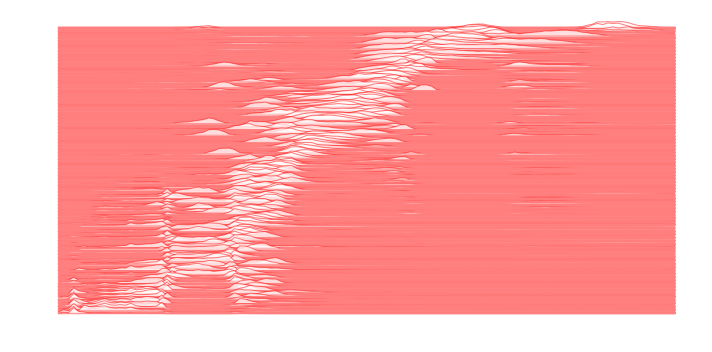

In [199]:
plotzgrp(zhist, sort=True)

In [16]:
%time grpid, zhist, zsim = groupbins(X, z, zedges, npct=12, min_groups=200, minfrac=0.005, maxfrac=0.05)

Grouping with ndata=5410171, nmin=27051, nmax=270509, nzbin=120, nfbin=1728.
Reduced to 1498 groups after 100 iterations.
Reduced to 1398 groups after 200 iterations.
Reduced to 1298 groups after 300 iterations.
Reduced to 1198 groups after 400 iterations.
Reduced to 1108 groups after 500 iterations.
Reduced to 1090 groups after 600 iterations.
Reduced to 1002 groups after 700 iterations.
Reduced to 907 groups after 800 iterations.
Reduced to 816 groups after 900 iterations.
Reduced to 738 groups after 1000 iterations.
Reduced to 648 groups after 1100 iterations.
Reduced to 559 groups after 1200 iterations.
Reduced to 473 groups after 1300 iterations.
Reduced to 388 groups after 1400 iterations.
Reduced to 296 groups after 1500 iterations.
Reduced to 200 groups after 1600 iterations.
Reached min_groups=200 after 1600 iterations.
CPU times: user 3min 45s, sys: 4.59 s, total: 3min 49s
Wall time: 37.6 s


In [17]:
%time grpid, zhist, zsim = groupbins(X, z, zedges, npct=15, min_groups=200, minfrac=0.005, maxfrac=0.05)

Grouping with ndata=5410171, nmin=27051, nmax=270509, nzbin=120, nfbin=3375.
Reduced to 2963 groups after 100 iterations.
Reduced to 2863 groups after 200 iterations.
Reduced to 2763 groups after 300 iterations.
Reduced to 2663 groups after 400 iterations.
Reduced to 2587 groups after 500 iterations.
Reduced to 2502 groups after 600 iterations.
Reduced to 2410 groups after 700 iterations.
Reduced to 2320 groups after 800 iterations.
Reduced to 2220 groups after 900 iterations.
Reduced to 2120 groups after 1000 iterations.
Reduced to 2081 groups after 1100 iterations.
Reduced to 2081 groups after 1200 iterations.
Reduced to 2049 groups after 1300 iterations.
Reduced to 1961 groups after 1400 iterations.
Reduced to 1891 groups after 1500 iterations.
Reduced to 1806 groups after 1600 iterations.
Reduced to 1726 groups after 1700 iterations.
Reduced to 1631 groups after 1800 iterations.
Reduced to 1556 groups after 1900 iterations.
Reduced to 1530 groups after 2000 iterations.
Reduced to 1

In [20]:
%time grpid, zhist, zsim = groupbins(X, z, zedges, npct=16, min_groups=200, minfrac=0.005, maxfrac=0.02)

Grouping with ndata=5410171, nmin=27051, nmax=108203, nzbin=120, nfbin=4096.
Reduced to 3587 groups after 100 iterations.
Reduced to 3487 groups after 200 iterations.
Reduced to 3387 groups after 300 iterations.
Reduced to 3287 groups after 400 iterations.
Reduced to 3245 groups after 500 iterations.
Reduced to 3166 groups after 600 iterations.
Reduced to 3068 groups after 700 iterations.
Reduced to 2991 groups after 800 iterations.
Reduced to 2921 groups after 900 iterations.
Reduced to 2821 groups after 1000 iterations.
Reduced to 2753 groups after 1100 iterations.
Reduced to 2753 groups after 1200 iterations.
Reduced to 2747 groups after 1300 iterations.
Reduced to 2668 groups after 1400 iterations.
Reduced to 2572 groups after 1500 iterations.
Reduced to 2478 groups after 1600 iterations.
Reduced to 2383 groups after 1700 iterations.
Reduced to 2321 groups after 1800 iterations.
Reduced to 2315 groups after 1900 iterations.
Reduced to 2223 groups after 2000 iterations.
Reduced to 2

In [36]:
%time grpid, zhist, zsim = groupbins(X, z, zedges, npct=20, min_groups=200, minfrac=0.005, maxfrac=0.02)

Grouping with ndata=5410171, nmin=27051, nmax=108203, nzbin=120, nfbin=8000.
Reduced to 6936 groups after 100 iterations.
Reduced to 6836 groups after 200 iterations.
Reduced to 6736 groups after 300 iterations.
Reduced to 6636 groups after 400 iterations.
Reduced to 6536 groups after 500 iterations.
Reduced to 6436 groups after 600 iterations.
Reduced to 6433 groups after 700 iterations.
Reduced to 6433 groups after 800 iterations.
Reduced to 6398 groups after 900 iterations.
Reduced to 6300 groups after 1000 iterations.
Reduced to 6200 groups after 1100 iterations.
Reduced to 6100 groups after 1200 iterations.
Reduced to 6000 groups after 1300 iterations.
Reduced to 5900 groups after 1400 iterations.
Reduced to 5807 groups after 1500 iterations.
Reduced to 5707 groups after 1600 iterations.
Reduced to 5626 groups after 1700 iterations.
Reduced to 5626 groups after 1800 iterations.
Reduced to 5626 groups after 1900 iterations.
Reduced to 5614 groups after 2000 iterations.
Reduced to 5

In [37]:
np.savez('groups20.npz', grpid=grpid, zhist=zhist, zsim=zsim)

In [113]:
%time grpid0, zhist0, zsim0 = groupbins(X, z, zedges, npct=20, min_groups=200, minfrac=0.005, maxfrac=0.02, weighted=False)

Grouping with ndata=5410171, nmin=27051, nmax=108203, nzbin=120, nfbin=8000.
Reduced to 6936 groups after 100 iterations.
Reduced to 6836 groups after 200 iterations.
Reduced to 6736 groups after 300 iterations.
Reduced to 6636 groups after 400 iterations.
Reduced to 6536 groups after 500 iterations.
Reduced to 6436 groups after 600 iterations.
Reduced to 6336 groups after 700 iterations.
Reduced to 6236 groups after 800 iterations.
Reduced to 6136 groups after 900 iterations.
Reduced to 6036 groups after 1000 iterations.
Reduced to 5936 groups after 1100 iterations.
Reduced to 5836 groups after 1200 iterations.
Reduced to 5736 groups after 1300 iterations.
Reduced to 5636 groups after 1400 iterations.
Reduced to 5536 groups after 1500 iterations.
Reduced to 5436 groups after 1600 iterations.
Reduced to 5336 groups after 1700 iterations.
Reduced to 5236 groups after 1800 iterations.
Reduced to 5136 groups after 1900 iterations.
Reduced to 5036 groups after 2000 iterations.
Reduced to 4

In [114]:
np.savez('groups20-cosine.npz', grpid=grpid0, zhist=zhist0, zsim=zsim0)

In [115]:
!ls -lh groups20*.npz

-rw-rw-r-- 1 dkirkby dkirkby 42M Aug 31 14:01 groups20-cosine.npz
-rw-rw-r-- 1 dkirkby dkirkby 42M Aug 31 10:49 groups20.npz


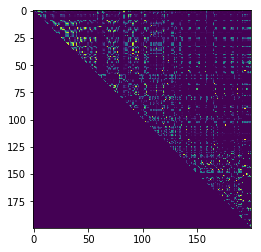

In [116]:
plt.imshow(zsim0 * np.triu(np.ones_like(zsim), 1));

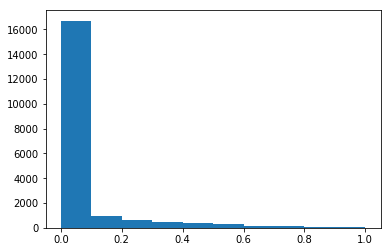

In [118]:
plt.hist(zsim0[np.where(np.triu(np.ones_like(zsim), 1) == 1)].reshape(-1));

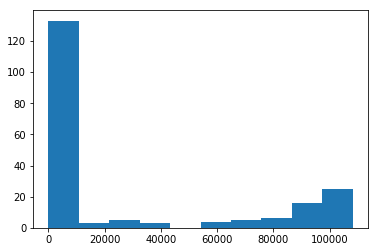

In [119]:
plt.hist(zhist0.sum(axis=1));

In [184]:
def plotzgrp(zhist, zedges=None, stretch=4, sort=True):
    ngrp, nzbin = zhist.shape
    if zedges is None:
        zc = np.arange(nzbin)
    else:
        zc = 0.5 * (zedges[1:] + zedges[:-1])
    zplot = zhist / zhist.max(axis=1, keepdims=True)
    if sort:
        zavg = np.sum(zhist * np.arange(nzbin), axis=1) / np.sum(zhist, axis=1)
        zplot = zplot[np.argsort(zavg)]
    fig = plt.figure(figsize=(10, 5))
    yoffsets = np.arange(ngrp) / stretch
    for dndz, dy in zip(zplot[::-1], yoffsets[::-1]):
        #plt.plot(zc, dndz + dy, 'r-', alpha=0.5)
        plt.fill_between(zc, dndz + dy, dy, facecolor=(1, 1, 1, 0.75), edgecolor=(1, 0, 0, 0.5), lw=1)
    plt.gca().axis('off')
    plt.tight_layout()

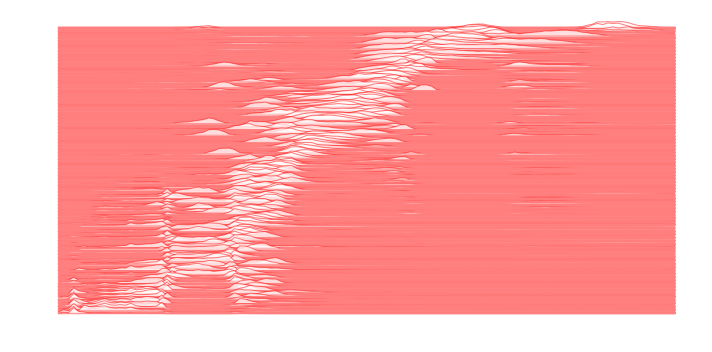

In [187]:
plotzgrp(zhist)
#plt.savefig('zgrp.png')

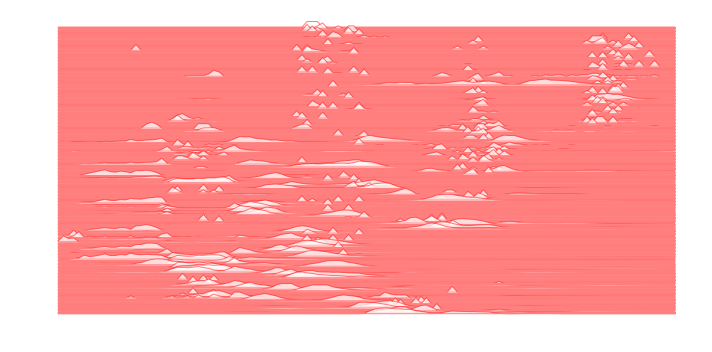

In [120]:
plotzgrp(zhist0)

In [64]:
import jax
import jax.numpy as jnp

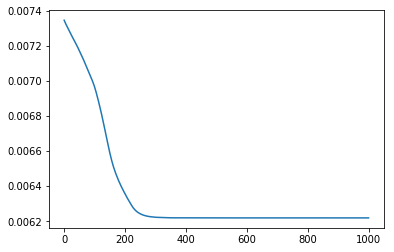

In [124]:
def embed(zsim, nstep=100, eta=0.01, alpha=1, seed=123):
    
    ngrp = len(zsim)
    
    # Initialize random latent space coordinates.
    gen = np.random.RandomState(seed)
    phi = jnp.array(gen.uniform(size=ngrp))
    offdiag = jnp.where(jnp.identity(ngrp) == 0)

    # Normalize the similarity matrix to obtain feature-space probabilities.
    p = jnp.array(zsim / zsim.sum(axis=1, keepdims=True)) ** alpha
    p /= p[offdiag].sum()
    assert jnp.all(p[offdiag] > 0)
    
    # Define a KL loss function.
    @jax.jit
    def KL(phi):
        # Calculate the latent space distance matrix with periodic boundary conditions.
        phi2 = phi.reshape(-1, 1)
        dphisq = (phi2 - phi) ** 2 + 1 - 2 * jnp.maximum(jnp.abs(phi2 - phi), 0.5)
        # Calculate student-t probabilities.
        q = 1 / (1 + dphisq)        
        q /= q[offdiag].sum()
        # Calculate KL(p || q)
        return jnp.sum(p[offdiag] * jnp.log(p[offdiag] / q[offdiag]))
    
    KL_value_grad = jax.jit(jax.value_and_grad(KL))
    
    losses = []
    for i in range(nstep):
        loss, grads = KL_value_grad(phi)
        phi -= eta * grads
        losses.append(float(loss))
        #print(i, losses[-1])
    plt.plot(losses)
    return phi

phi = embed(zsim, eta=10., nstep=1000, seed=1)

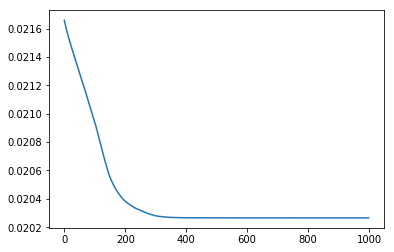

In [125]:
phi2 = embed(zsim, eta=10., nstep=1000, seed=1, alpha=2)

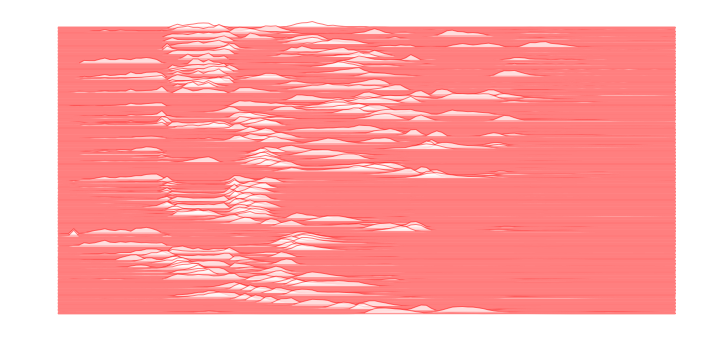

In [80]:
plotzgrp(zhist)

In [127]:
zavg = np.sum(zhist * np.arange(zhist.shape[1]), axis=1) / np.sum(zhist, axis=1)

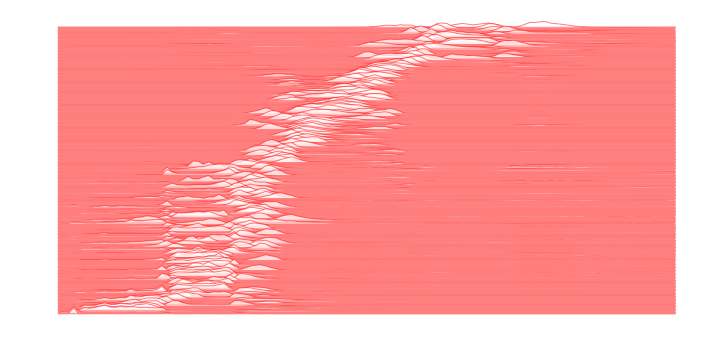

In [130]:
plotzgrp(zhist[np.argsort(zavg)])

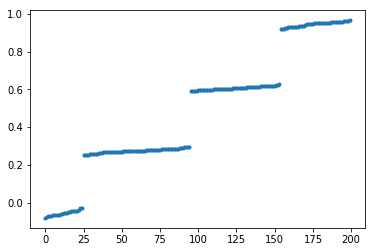

In [102]:
plt.plot(phi[np.argsort(phi)], '.')

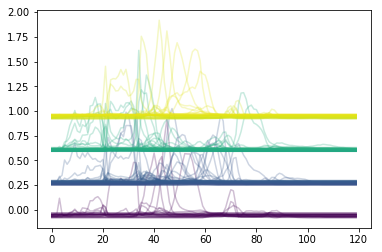

In [112]:
def plotphi(phi, cmap='viridis'):
    cmap = plt.get_cmap(cmap)
    norm = zhist.max()
    for i in np.argsort(phi):
        c = cmap(phi[i])
        plt.plot(phi[i] + zhist[i] / norm, alpha=0.25, c=c)
        
plotphi(phi)